In [198]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import linalg
import torchvision
import torchvision.transforms as transforms
import random 
import numpy as np

In [199]:
seed_value = 42
torch.manual_seed(seed_value)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

fourth_train_transform = transforms.Compose(
               [transforms.RandomHorizontalFlip(),
                transforms.RandomCrop(size=32, padding=[0, 2, 3, 4]),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 1000

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=fourth_train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=fourth_train_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [200]:
#In this cell we create the mask we use for masking only the weights we are going to regularize
set_ = {0,    1,    2,    3,    4,    32,   33,   34,   35,   36,   64,   65,   66,   67,   68,   96,   97,   98,   99,   100,  128,  129,  130,  131,  132,
        1024, 1025, 1026, 1027, 1028, 1056, 1057, 1058, 1059, 1060, 1088, 1089, 1090, 1091, 1092, 1120, 1121, 1122, 1123, 1124, 1152, 1153, 1154, 1155, 1156,
        2048, 2049, 2050, 2051, 2052, 2080, 2081, 2082, 2083, 2084, 2112, 2113, 2114, 2115, 2116, 2144, 2145, 2146, 2147, 2148, 2176, 2177, 2178, 2179, 2180}
matrix = []

# Create the first row of the mask
row = np.array([1 if i in set_ else 0 for i in range(3072)])
matrix.append(row)

# Create the remaining 783 rows
for j in range(783):
    row_shifted = np.array([1 if (i - j - 1) in set_ else 0 for i in range(len(matrix[-1]))])
    matrix.append(row_shifted)

# Convert the list of lists (matrix) to a NumPy array
mask = np.array(matrix)
mask = torch.tensor(mask)


In [201]:
class Net(nn.Module):
    def __init__(self):
       super().__init__()
       self.fc0 = nn.Linear(3072, 1 * 28 * 28)
       self.fc1 = nn.Linear(1 * 28 * 28, 120)
       self.fc2 = nn.Linear(120, 84)
       self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc0(x))
        #this is the penalty term if we use the mask
        penalty_term = linalg.norm(torch.mul(self.fc0.weight, mask).flatten(), ord = 1)
        #this is the penalty term if we do not use the mask
        #penalty_term = linalg.norm(self.fc0.weight.flatten(), ord = 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x, penalty_term

net = Net()

In [202]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [203]:
for epoch in range(500):

    # Training loop
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs[0], labels) + 1000*(outputs[1])
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation loop
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs[0].data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Print training loss and validation accuracy
    print(f'Epoch {epoch + 1}')
    print(f'Accuracy on Validation Set: {100 * correct // total}%')

print('Finished Training')

Epoch 1
Accuracy on Validation Set: 11%
Epoch 2
Accuracy on Validation Set: 15%
Epoch 3
Accuracy on Validation Set: 15%
Epoch 4
Accuracy on Validation Set: 19%
Epoch 5
Accuracy on Validation Set: 18%
Epoch 6
Accuracy on Validation Set: 22%
Epoch 7
Accuracy on Validation Set: 22%
Epoch 8
Accuracy on Validation Set: 24%
Epoch 9
Accuracy on Validation Set: 25%
Epoch 10
Accuracy on Validation Set: 26%
Epoch 11
Accuracy on Validation Set: 26%
Epoch 12
Accuracy on Validation Set: 28%
Epoch 13
Accuracy on Validation Set: 27%
Epoch 14
Accuracy on Validation Set: 30%
Epoch 15
Accuracy on Validation Set: 30%
Epoch 16
Accuracy on Validation Set: 31%
Epoch 17
Accuracy on Validation Set: 30%
Epoch 18
Accuracy on Validation Set: 32%
Epoch 19
Accuracy on Validation Set: 31%
Epoch 20
Accuracy on Validation Set: 33%
Epoch 21
Accuracy on Validation Set: 32%
Epoch 22
Accuracy on Validation Set: 33%
Epoch 23
Accuracy on Validation Set: 34%
Epoch 24
Accuracy on Validation Set: 35%
Epoch 25
Accuracy on Vali

KeyboardInterrupt: 

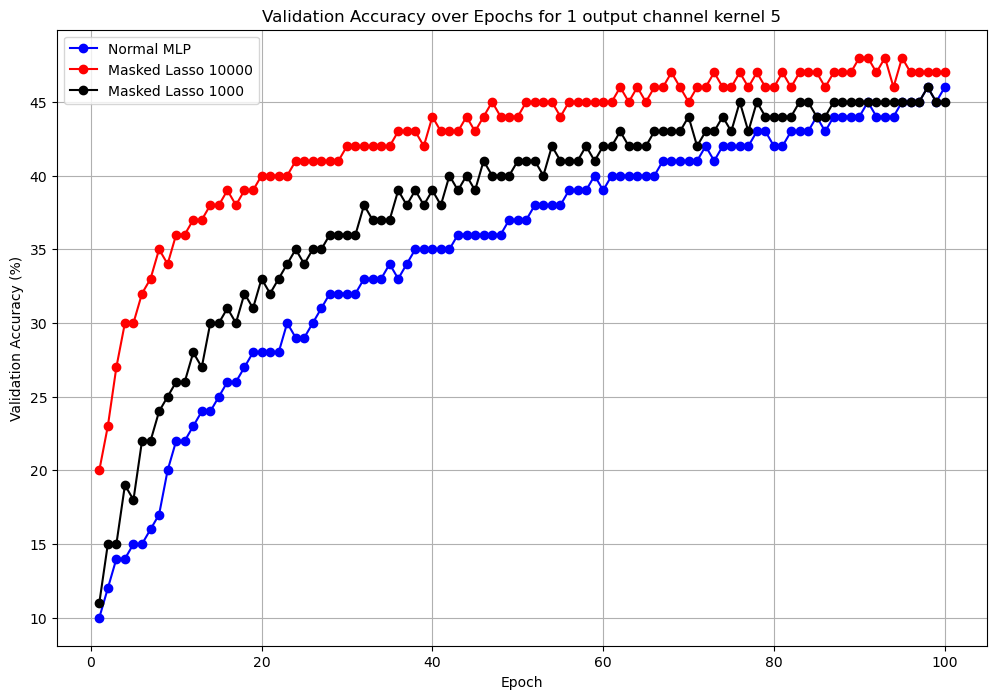

In [204]:
import matplotlib.pyplot as plt

epochs_set1 = list(range(1, 101))
validation_accuracy_set1 = [10,12,14,14,15,15,16,17,20,22,
 22,23,24,24,25,26,26,27,28,28,
 28,28,30,29,29,30,31,32,32,32,
 32,33,33,33,34,33,34,35,35,35,
 35,35,36,36,36,36,36,36,37,37,
 37,38,38,38,38,39,39,39,40,39,
 40,40,40,40,40,40,41,41,41,41,
 41,42,41,42,42,42,42,43,43,42,
 42,43,43,43,44,43,44,44,44,44,
 45,44,44,44,45,45,45,46,45,46]



epochs_set2 = list(range(1, 101))
validation_accuracy_set2 = [20,23,27,30,30,32,33,35,34,36,
 36,37,37,38,38,39,38,39,39,40,
 40,40,40,41,41,41,41,41,41,42,
 42,42,42,42,42,43,43,43,42,44,
 43,43,43,44,43,44,45,44,44,44,
 45,45,45,45,44,45,45,45,45,45,
 45,46,45,46,45,46,46,47,46,45,
 46,46,47,46,46,47,46,47,46,46,
 47,46,47,47,47,46,47,47,47,48,
 48,47,48,46,48,47,47,47,47,47]


epochs_set3 = list(range(1, 101))
validation_accuracy_set3 = [11,15,15,19,18,22,22,24,25,26,
 26,28,27,30,30,31,30,32,31,33,
 32,33,34,35,34,35,35,36,36,36,
 36,38,37,37,37,39,38,39,38,39,
 38,40,39,40,39,41,40,40,40,41,
 41,41,40,42,41,41,41,42,41,42,
 42,43,42,42,42,43,43,43,43,44,
 42,43,43,44,43,45,43,45,44,44,
 44,44,45,45,44,44,45,45,45,45,
 45,45,45,45,45,45,45,46,45,45]

plt.figure(figsize=(12, 8))
plt.plot(epochs_set1, validation_accuracy_set1, marker='o', linestyle='-', color='b', label='Normal MLP')
plt.plot(epochs_set2, validation_accuracy_set2, marker='o', linestyle='-', color='r', label='Masked Lasso 10000')
plt.plot(epochs_set3, validation_accuracy_set3, marker='o', linestyle='-', color='k', label='Masked Lasso 1000')


plt.title('Validation Accuracy over Epochs for 1 output channel kernel 5')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()